In [1]:
#Collap Drive Bağlama
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import joblib
from sklearn.metrics import classification_report

In [3]:
#Train ve Test Veri Setleri Kurulumu

path = "/content/drive/MyDrive/Binovist  Sentiment Analysis/data/Hepsiburada Dataset 492k(%10 test)/"

df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")

dataframes = {'df_train': df_train, 'df_test': df_test}

yes_responses = {'evet', 'yes', 'y', '1', 'tamam', 'onay', 'olur', 'e'}
no_responses = {'hayır', 'no', 'n', '0', 'hayir', 'olmaz', 'h'}

In [5]:
# Label'ları sayısal değerlere dönüştürmek için
label_mapping = {'Positive': 2, 'Notr': 1, 'Negative': 0}
for name, df in dataframes.items():
  df['label_numeric'] = df['label'].map(label_mapping)
  print(name + " Hatasız Eklendi")

df_train Hatasız Eklendi
df_test Hatasız Eklendi


In [6]:
for name, df in dataframes.items():
  print(f"\nProcessing {name}...")
  duplicates_df = pd.read_csv(path + name + "_DuplicatedControl.csv")

  # Metin uzunluklarının ortalamasını ve modunu hesapla
  mean_length = duplicates_df['text_length'].mean()
  mode_length = duplicates_df['text_length'].mode()[0]

  # Duplicate count ortalaması ve modu
  mean_dupfrequency_length = duplicates_df['count'].mean()
  mode_dupfrequency_length = duplicates_df['count'].mode()[0]

  # Uzun ve yüksek sayıda tekrar eden metinleri bulma
  long_and_high_freq_texts = duplicates_df[(duplicates_df['text_length'] > mean_length) & (duplicates_df['count'] > mean_dupfrequency_length)]

  if long_and_high_freq_texts.empty:
    print("Çıkarılacak cümle bulunmamaktadır.")

    filtered_df = df

  else:
      # Sonuçları yazdırma
      print("Long and High Frequency Texts:")
      print(long_and_high_freq_texts[['text', 'count']])
      print("Cümle sayısı: " + str(len(long_and_high_freq_texts)))
      print("Çıkarılacak Toplam Cümle Sayısı: " + str(long_and_high_freq_texts['count'].sum()))

      # Kullanıcı girdisi
      while True:
          user_input = input("Bu cümleleri veri setinden çıkarmak ister misiniz? (Evet/Hayır): ").strip().lower()
          if user_input in yes_responses:
              # Uzun ve yüksek frekanslı metinleri ana veri setinden çıkarma
              print("Çıkarılmadan Önceki Veri Sayısı " + str(len(df)))

              filtered_df = df[~df['text'].apply(lambda x: any(phrase in x for phrase in long_and_high_freq_texts['text']))]

              print("Çıkarılmadan Önceki Veri Sayısı " + str(len(filtered_df)) + " Fark: " + str(len(df) - len(filtered_df)))


              break
          elif user_input in no_responses:
              print("Cümleler çıkarılmadı.")
              filtered_df = df
              break
          else:
              print("Geçersiz giriş. Lütfen 'Evet' veya 'Hayır' olarak cevaplayın.")

  # Filtrelenmiş veri setini CSV dosyasına kaydetme
  filtered_csv_path = path + name + "_filtered_test.csv"
  filtered_df.to_csv(filtered_csv_path, index=False)
  print(f"Filtered dataset saved to {filtered_csv_path}\n")



Processing df_train...
Long and High Frequency Texts:
                                                 text  count
6    Arkadaşlar 'imdb.com' sitesinde Hababam Sınıf...      7
20   Daha önce yaşamın değerini anlatan filmler iz...      4
24  önce tatil ne olduğunu öğrensinler sonra gelsi...      3
27  berbat yorgunluk tan baska bi sey olusmadimerh...      3
30  rezaletokul gezisi olarak arkadailarla gittik ...      3
35  superdısuper bır otel aılemle yaptıgım nadır g...      3
36  iğrençtibu oteli arkadaşlarımızın ortak organi...      3
38   bu film için yapacak pek fazla yorum bulamıyo...      3
42  otel berbatsu anda öteldeyim bu otel kon olara...      3
55  rezaletben antalyada o kadar hotellerde kaldim...      3
Cümle sayısı: 10
Çıkarılacak Toplam Cümle Sayısı: 35
Bu cümleleri veri setinden çıkarmak ister misiniz? (Evet/Hayır): e
Çıkarılmadan Önceki Veri Sayısı 440679
Çıkarılmadan Önceki Veri Sayısı 440644 Fark: 35
Filtered dataset saved to /content/drive/MyDrive/Binovist  Sentimen

In [7]:
df_train_filtered = pd.read_csv(path + "df_train_filtered_test.csv")
df_test_filtered = pd.read_csv(path + "df_test_filtered_test.csv")

dataframes_filtered = {'df_train': df_train_filtered, 'df_test': df_test_filtered}

In [8]:
for name, df in dataframes_filtered.items():
  print(df.describe())

       label_numeric
count  440644.000000
mean        1.419965
std         0.688868
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
       label_numeric
count   48965.000000
mean        1.419912
std         0.688925
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000


In [9]:
# Gerekli nltk paketlerini indir
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Ön İşleme Fonksiyonu
def pre_processing(text):
    text = text.lower()  # Büyük harften Küçük harfe çevirme
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz ]", "", text)  # Harf içermeyen her türlü öğeyi silme işlemi
    text = word_tokenize(text)  # Cümledeki kelimeleri birbirinden ayırır
    text = [word for word in text if not word in stop_words]  # Stop wordler'i (Türkçe Dolgu Sözcükleri) Silme işlemi
    lemma = WordNetLemmatizer()  # Kelimenin köküne ulaşma aşaması
    text = [lemma.lemmatize(word) for word in text]  # Kelimeleri köklerine indirgeme
    text = " ".join(text)
    return text

# Ekstra stopwords ekleme
stop_words = stopwords.words("turkish")
stop_words.extend(["bir","film","filmi","filme","filmde","filmden","filmin","kadar","bi","ben"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
for name, df in dataframes_filtered.items():
  print(f"\nProcessing {name}...")
  # Ön İşleme Fonksiyonunu Uygulama
  df['processed_text'] = df['text'].apply(pre_processing)
  print(df.head())

  # Yeni dengeli veri setini kaydet (isteğe bağlı)
  filtered_csv_path = path + name + "_filtered_test.csv"
  df.to_csv(filtered_csv_path, index=False)
  print(f"Filtered dataset saved to {filtered_csv_path}\n")

df_train_filtered = pd.read_csv(path + "df_train_filtered_test.csv")
df_test_filtered = pd.read_csv(path + "df_test_filtered_test.csv")

dataframes_filtered = {'df_train': df_train_filtered, 'df_test': df_test_filtered}

#Eğer Temizleme Sonrası Boş Veri Olursa Çıkarma İşlemi
for name, df in dataframes_filtered.items():
  dataframes_filtered[name] = df.dropna()


Processing df_train...
                                                text     label  \
0  ürünü hepsiburadadan alalı 3 hafta oldu. orjin...  Positive   
1  ürünlerden çok memnunum, kesinlikle herkese ta...  Positive   
2      hızlı kargo, temiz alışveriş.teşekkür ederim.  Positive   
3               Çünkü aranan tapınak bu bölgededir .      Notr   
4  bu telefonu başlıca alma nedenlerim ise elimde...  Positive   

          dataset  label_numeric  \
0  urun_yorumlari              2   
1  urun_yorumlari              2   
2  urun_yorumlari              2   
3            wiki              1   
4  urun_yorumlari              2   

                                      processed_text  
0  ürünü hepsiburadadan alalı hafta oldu orjinal ...  
1  ürünlerden memnunum kesinlikle herkese tavsiye...  
2         hızlı kargo temiz alışverişteşekkür ederim  
3                          aranan tapınak bölgededir  
4  telefonu başlıca alma nedenlerim elimdeki sams...  
Filtered dataset saved to /conte

In [11]:
# Oluştururalan yeni temiz verinin veri setine ekstra bir kolonlar'ı
df_train_filtered = dataframes_filtered['df_train']
df_test_filtered = dataframes_filtered['df_test']

X_train=df_train_filtered["processed_text"]
X_test=df_test_filtered["processed_text"]
y_train=df_train_filtered["label_numeric"]
y_test=df_test_filtered["label_numeric"]

print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (440556,)
x_test (48951,)
y_train (440556,)
y_test (48951,)


In [12]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())
print(y_train.isnull().sum())
print(y_test.isnull().sum())

0
0
0
0


In [13]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
# Pipeline oluşturma
pipeline  = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LR(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

In [14]:
# Nihai modelin oluşturulması hiperparametre optimizasyonunu önceki modele göre uyarladım zaman kaybetmemek için
final_pipeline = pipeline.set_params(tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), clf__C=10)
final_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('clf',
                 LogisticRegression(C=10, max_iter=500,
                                    multi_class='multinomial'))])

In [29]:
joblib.dump(final_pipeline, path + "Modeller/" + 'LogicticRegresyon_Tam_Veri_Model.pkl')

# Modeli yükleme
#loaded_model = joblib.load(path + "Modeller/" + 'LogicticRegresyon_Tam_Veri_Model.pkl')

['/content/drive/MyDrive/Binovist  Sentiment Analysis/data/Hepsiburada Dataset 492k(%10 test)/Modeller/LogicticRegresyon_Tam_Veri_Model.pkl']

In [15]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    print("Confusion Matrix :\n")
    print(str(conf_mat) + "\n")
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(3), ['True Negative', 'True Neutral', 'True Positive'])
    plt.xticks(range(3), ['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'], rotation=10)
    plt.colorbar();
    for i in range(3):
        for j in range(3):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      5655
           1       0.96      0.98      0.97     17087
           2       0.94      0.95      0.95     26209

    accuracy                           0.94     48951
   macro avg       0.92      0.89      0.90     48951
weighted avg       0.94      0.94      0.94     48951

Train Accuracy : 0.990
Test Accuracy : 0.939 

0.9160688548414067 : is the precision score
0.8901282814833472 : is the recall score
0.9017100812871396 : is the f1 score 

Confusion Matrix :

[[ 4135   147  1373]
 [   41 16830   216]
 [  726   474 25009]]



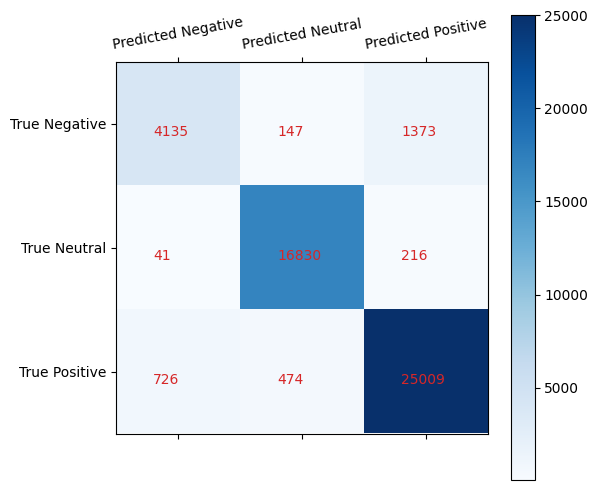

In [16]:
# Test etme sonuçları kontrol etme
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

#cv_scores = cross_val_score(LogisticRegression, X_train, y_train, cv=50)
#print("CV average score: %.2f" % cv_scores.mean())


result = final_pipeline.predict(X_test)
cr = classification_report(y_test, result)
print(cr)


print('Train Accuracy : %.3f'%final_pipeline.score(X_train, y_train))
print('Test Accuracy : %.3f'%final_pipeline.score(X_test, y_test), "\n")



y_pred = final_pipeline.predict(X_test)
print(precision_score(y_test, y_pred ,average='macro') , ": is the precision score")
print(recall_score(y_test, y_pred,average='macro'), ": is the recall score")
print(f1_score(y_test, y_pred ,average='macro'), ": is the f1 score \n")

plot_confusion_matrix(y_test, final_pipeline.predict(X_test))

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5)

# Cross-validation ile doğruluk skoru hesaplama
scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='accuracy')

# Sonuçları yazdır
print(f'Her katlamadaki doğruluk skorları: {scores}')
print(f'Ortalama doğruluk skoru: {scores.mean()}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Her katlamadaki doğruluk skorları: [0.93777238 0.93869097 0.93804406 0.93971241 0.93874772]
Ortalama doğruluk skoru: 0.9385935064353358


In [17]:
text_list = ["Bu film çok güzel çok beğendim.", "Çok kötü bir film olmuş kesinlikle izlenmemesi gerekiyor.", "kırmızı araba", "Kesinlikle İzleyin",
             "kesinlikle izlemeyin", "Binovist Çok Güzel Bir Şirket", "Hayat Çok Sıkıcı", "İnsanların 2 ayağı vardır", "Rubic Cube", "Kırmızı", "Binovist", "Sen Çok Şişkosun"]

max_length = max(len(sentence) for sentence in text_list) +5

for i, sentence in enumerate([sentence + ' ' for sentence in text_list]):

  prediction=final_pipeline.predict([text_list[i]])
  proportion=final_pipeline.predict_proba([text_list[i]])

  #print(prediction[0])

  if prediction[0] == 0:
      sentiment = f"{proportion[0][0] * 100:.2f}% Negative"
  elif prediction[0] == 1:
      sentiment = f"{proportion[0][1] * 100:.2f}% Neutral"
  else:
      sentiment = f"{proportion[0][2] * 100:.2f}% Positive"

  print(f"{sentence.ljust(max_length, '-')}> {sentiment}")

Bu film çok güzel çok beğendim. ------------------------------> 99.81% Positive
Çok kötü bir film olmuş kesinlikle izlenmemesi gerekiyor. ----> 98.99% Negative
kırmızı araba ------------------------------------------------> 63.93% Neutral
Kesinlikle İzleyin -------------------------------------------> 80.92% Positive
kesinlikle izlemeyin -----------------------------------------> 99.14% Negative
Binovist Çok Güzel Bir Şirket --------------------------------> 69.91% Positive
Hayat Çok Sıkıcı ---------------------------------------------> 56.97% Negative
İnsanların 2 ayağı vardır ------------------------------------> 99.98% Neutral
Rubic Cube ---------------------------------------------------> 46.68% Positive
Kırmızı ------------------------------------------------------> 95.66% Neutral
Binovist -----------------------------------------------------> 73.63% Neutral
Sen Çok Şişkosun ---------------------------------------------> 51.16% Positive
